# A Bayesian Network for Modeling and Explaining Wine Quality Assessment


## Abstract
The goal of this notebook is to build a predictive model for wine quality using Bayesian Networks. We use the Wine Quality dataset from the UCI Machine Learning Repository, which contains physicochemical measurements of red and white wines along with quality ratings. Bayesian Networks provide a powerful probabilistic modeling framework that captures the dependencies between input features and the target variable — wine quality. Through exploratory data analysis, model construction, and evaluation, this project demonstrates how Bayesian approaches can be applied to classification tasks in the context of food quality assessment.

## Dataset Overview
The dataset used in this project comes from the UCI Machine Learning Repository:
🍷 Wine Quality Data Set — https://archive.ics.uci.edu/dataset/186/wine+quality
There are two variants of the dataset: red wine and white wine. Each record represents a wine sample described by a set of physicochemical properties along with a quality score rated by human experts.


The dataset contains the following attributes:
| Variable                 | Description                                                           |
| ------------------------ | --------------------------------------------------------------------- |
| **fixed acidity**        | Amount of non-volatile acids in wine (g/dm³)                          |
| **volatile acidity**     | Amount of volatile acids (acetic acid etc.) — affects sharpness/aroma |
| **citric acid**          | Amount of citric acid — can add freshness & flavor                    |
| **residual sugar**       | Sugar left after fermentation (g/dm³)                                 |
| **chlorides**            | Salt level measured as chloride content                               |
| **free sulfur dioxide**  | Indicator of antimicrobial protection (mg/dm³)                        |
| **total sulfur dioxide** | Total SO₂ content (mg/dm³)                                            |
| **density**              | Density of the wine sample (g/cm³)                                    |
| **pH**                   | Measure of acidity/basicity                                           |
| **sulphates**            | Sulphate levels — preservative quality                                |
| **alcohol**              | Alcohol percentage by volume                                          |
| **quality**              | Wine quality score (integer 0–10, from expert tasting)                |


In [2]:
import pgmpy as pg
import numpy as np
import pandas as pd


In [3]:
# merging two csv files into one

red_wine_data = pd.read_csv(
    "data/winequality-red.csv", 
    sep=r'\s*;\s*|\t',  # Handles both semicolons and tabs
    engine='python'
)

white_wine_data = pd.read_csv(
    "data/winequality-white.csv", 
    sep=r'\s*;\s*|\t',  # Handles both semicolons and tabs
    engine='python'
)


red_wine_data.columns = [col.strip().replace('"', '') for col in red_wine_data.columns]
white_wine_data.columns = [col.strip().replace('"', '') for col in white_wine_data.columns]

merged_data = pd.concat([red_wine_data, white_wine_data]).reset_index(drop=True)
merged_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# show min and max values for each column
min_values = merged_data.min()
max_values = merged_data.max()
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values, 'diff': max_values - min_values})
min_max_df

,min,max,diff
fixed acidity,3.80000,15.90000,12.10000
volatile acidity,0.08000,1.58000,1.50000
citric acid,0.00000,1.66000,1.66000
residual sugar,0.60000,65.80000,65.20000
chlorides,0.00900,0.61100,0.60200
free sulfur dioxide,1.00000,289.00000,288.00000
total sulfur dioxide,6.00000,440.00000,434.00000
density,0.98711,1.03898,0.05187
pH,2.72000,4.01000,1.29000
sulphates,0.22000,2.00000,1.78000


In [5]:

# check for each column if diffrence between min and max is greater than 2 make a 5. bins else just get a ceiling of the max value
binned_data = merged_data.copy()
for column in binned_data.columns:
    if binned_data[column].max() - binned_data[column].min() < 2:
        binned_data[column] = pd.cut(binned_data[column], bins=5, labels=False)
    else:
        binned_data[column] = np.round(binned_data[column])

binned_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,2,0,2.0,0,11.0,34.0,1,3,0,9.0,5
1,8.0,2,0,3.0,0,25.0,67.0,0,1,1,10.0,5
2,8.0,2,0,2.0,0,15.0,54.0,0,2,1,10.0,5
3,11.0,0,1,2.0,0,17.0,60.0,1,1,1,10.0,6
4,7.0,2,0,2.0,0,11.0,34.0,1,3,0,9.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.0,0,0,2.0,0,24.0,92.0,0,2,0,11.0,6
6493,7.0,0,1,8.0,0,57.0,168.0,0,1,0,10.0,5
6494,6.0,0,0,1.0,0,30.0,111.0,0,1,0,9.0,6
6495,6.0,0,0,1.0,0,20.0,110.0,0,2,0,13.0,7


In [6]:
from pgmpy.models import DiscreteBayesianNetwork
target_variable = 'quality'
network = [(target_variable, x) for x in binned_data.columns[:-1]]
naive_bayes = DiscreteBayesianNetwork(network)

/Users/sara/Documents/Uni_AI/semester 1/Fundumental AI/module3(Torroni)/mini-project/pgm-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


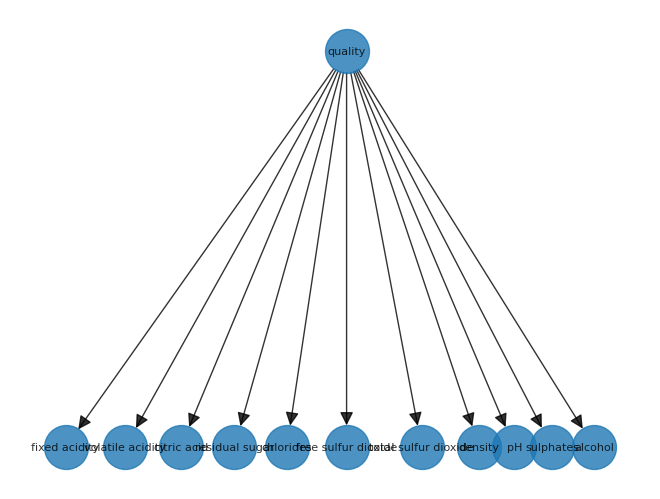

In [10]:
import networkx as nx
pos = nx.nx_agraph.graphviz_layout(naive_bayes, prog="dot")
nx.draw(naive_bayes, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

In [11]:

from pgmpy.models import BayesianModel

custom_model = BayesianModel([
    ('alcohol', 'quality'),
    ('sulphates', 'quality'),
    ('volatile acidity', 'quality'),
    ('citric acid', 'quality'),
    ('residual sugar', 'quality'),
    ('chlorides', 'quality'),
    ('density', 'quality'),
    ('pH', 'quality'),
    ('free sulfur dioxide', 'quality'),
    ('total sulfur dioxide', 'quality'),
    ('fixed acidity', 'quality'),
    ('quality', 'quality_label')
])
custom_model.add_node('quality_label')  


ImportError: cannot import name 'BayesianModel' from 'pgmpy.models' (/Users/sara/Documents/Uni_AI/semester 1/Fundumental AI/module3(Torroni)/mini-project/pgm-env/lib/python3.11/site-packages/pgmpy/models/__init__.py)